In [3]:
import json
import itertools
from typing import Tuple, List, Iterable

from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, JpegImagePlugin, ImageFont
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import cm


In [3]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [4]:
first_image = train['X'][:, :, :, 0]
second_image = train['X'][:, :, :, 1]
third_image = train['X'][:, :, :, 2]
print(f'Image shape is: {first_image.shape}')

Image shape is: (32, 32, 3)


/home/tave/PycharmProjects/pose_estimation_live/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


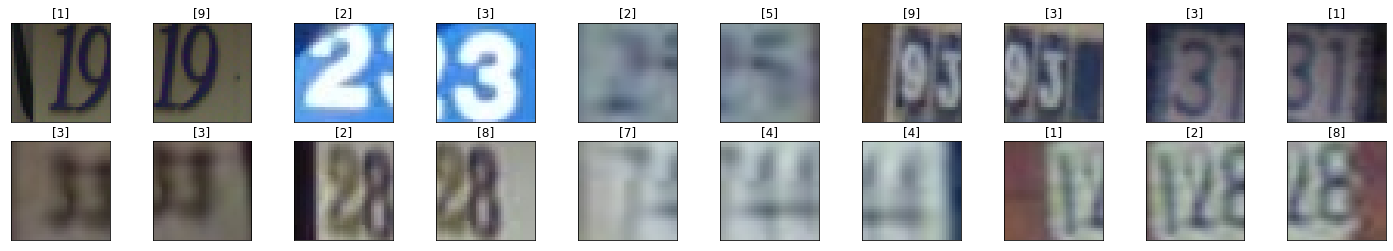

In [5]:
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(train['X'][:, :, :, idx])
    ax.set_title(train['y'][idx])

plt.show()

In [6]:
with open('./annotations/person_keypoints_train2017.json', 'r') as _file:
    train_key_points = json.load(_file)

In [7]:
annotations = train_key_points['annotations']
annotations[0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [8]:
print(train_key_points['categories'][0]['keypoints'])

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


In [9]:
first_image_info = annotations[0]
print(f'Image id is {first_image_info["image_id"]}')
target_image = '{}.jpg'.format(str(first_image_info["image_id"]).rjust(12, '0'))
print(f'Target image is {target_image}')

Image id is 537548
Target image is 000000537548.jpg


In [10]:
def draw_bbox(img: JpegImagePlugin.JpegImageFile, points: Tuple[float, float, float, float]) -> ImageDraw.Draw:
    """Draws bbox on the image"""
    x_coord, y_coord, width, height = points
    img = img.convert('RGBA')
    overlay = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw.rectangle((
        (x_coord, y_coord), 
        (x_coord + width, y_coord + height)), 
        fill=(128,255,255,90), 
        outline=(210,255,255,120),
        width=3
    )
    return Image.alpha_composite(img, overlay)

In [11]:
def crop_bbox(img: JpegImagePlugin.JpegImageFile, points: Tuple[float, float, float, float]) -> ImageDraw.Draw:
    # to_return = img.crop((points[0], points[1], points[0] + points[2], points[1] + points[3]))
    to_return = img.resize((256, 192), box=(points[0], points[1], points[0] + points[2], points[1] + points[3]))
    return to_return

In [12]:
def get_image_name(image_id: int) -> str:
    return '{}.jpg'.format(str(image_id).rjust(12, '0'))

In [13]:
FONT = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 12)
def draw_key_points(img: Image.Image, key_points: List[Tuple[str, List]]) -> Image.Image:
    drawing = ImageDraw.Draw(img)
    for point in key_points:
        if point[1][2] != 0:
            # drawing.point(xy=[point[1][0], point[1][1]], fill='blue')
            drawing.ellipse(xy=[point[1][0], point[1][1], point[1][0] + 3, point[1][1] + 3], fill='blue')
            drawing.text((point[1][0], point[1][1]), text=point[0], font=FONT)
    return img

In [14]:
def group_by_n_elements(iterable: List, number_of_elements: int) -> List:
    return [iterable[x: x + number_of_elements] for x in range(0, len(iterable), number_of_elements)]

In [15]:
def group_with_body_parts(coordinates: List) -> List:
    body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
    grouped = group_by_n_elements(iterable=coordinates, number_of_elements=3)
    result = itertools.zip_longest(body_parts, grouped)
    return list(result)

### Testing on one image

In [16]:
target_bbox = first_image_info['bbox']
with Image.open(f'./train2017/{target_image}') as im:
    # image_with_bbox = draw_bbox(img=im, points=target_bbox)
    # cropped_image = crop_bbox(img=im, points=target_bbox)
    # plt.imshow(cropped_image)    
    plt.show()


### Cropping images

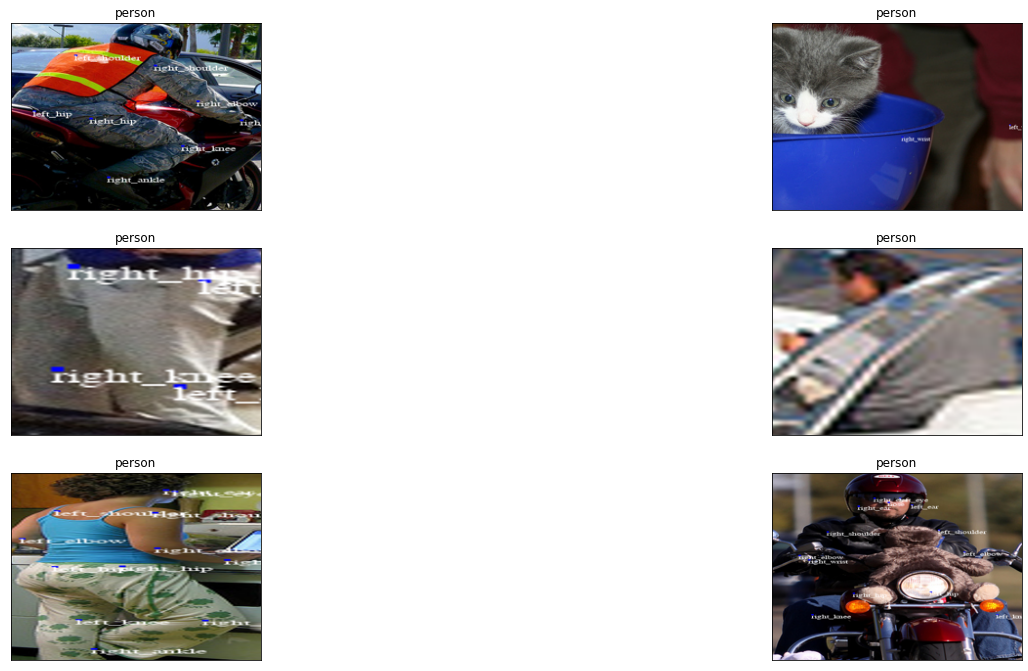

In [17]:
fig = plt.figure(figsize=(25, 20))

cropped_images = []

for idx in range(6):
    ax = fig.add_subplot(5, 2, idx + 1, xticks=[], yticks=[])
    target_image = get_image_name(image_id=annotations[idx]['image_id'])
    with Image.open(f'./train2017/{target_image}') as im:
        # image_with_bbox = draw_bbox(img=im, points=annotations[idx]['bbox'])
        image_with_points = draw_key_points(img=im, key_points=group_with_body_parts(annotations[idx]['keypoints']))
        cropped_image = crop_bbox(img=image_with_points, points=annotations[idx]['bbox'])
        cropped_images.append(cropped_image)
        plt.imshow(cropped_image)
        ax.set_title('person')
plt.show()

### Another way

In [1]:
# read annotation json file
import json
from pprint import pprint

keypoints_filename = 'annotations/person_keypoints_val2017.json'
json_file =  open(keypoints_filename)
kp_dataset = json.load(json_file)

# get sample annotation
kp_data = kp_dataset['annotations'][0]

# get 17 keypoint names
kp_categories = kp_dataset['categories'][0]['keypoints']
pprint(kp_categories)

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']


In [4]:
# Extract the keypoints as (x,y,v) tuples. There should be 17 tuples. 
# arrange keypoints as tuple
keypoints_list = np.asarray(kp_data['keypoints'])
  
# keypoints have 3 columns, x,y,v
keypoints_3d = np.reshape(keypoints_list,(17,3))
keypoints = keypoints_3d[:,:2]

# check if keypoints are valid 
# V==(0: does not exist, 1:not visible, 2: visible)
gt_validity = keypoints_3d[:,2]>0

In [5]:
# crop person and rescale to input image size
input_width=192
input_height=256

# image loading, cropping and resizing
def crop_and_resize_image(annotations, base_path = './val2017', height=256, width=192):

    # Parse the annotations
    x_start, y_start, box_w, box_h = annotations['bbox']
    img_id = str(annotations['image_id'])

    # Open to Image
    img_name = '000000000000'
    img_name = img_name[0:len(img_name) - len(img_id)] + img_id
    orig_img = Image.open(base_path + '/' + img_name + '.jpg')

    # Rescale Input Image
    img_w, img_h = orig_img.size
    rescaled_img = orig_img.resize((width,height), box=(x_start, y_start, x_start+box_w, y_start+box_h))
    
    print ("original image size:", img_w, img_h)
    print ("resized image size:",rescaled_img.size)
    print ("Box size:     ", box_w, box_h)
    print ("Box location: ", x_start,y_start)
    
    return orig_img, rescaled_img
img_orig, img_rescaled = crop_and_resize_image(kp_data,height=input_height,width=input_width)

# rescale keypoints to match new image size
x_start, y_start, box_w, box_h = kp_data['bbox']
box_offset = np.asarray([x_start,y_start])
box_dims = np.asarray([box_w,box_h])
input_dims = np.asarray([input_width,input_height])
keypoints = np.round((keypoints - box_offset) * input_dims / box_dims).astype(int)

original image size: 480 640
resized image size: (192, 256)
Box size:      300.58 372.5
Box location:  73.35 206.02


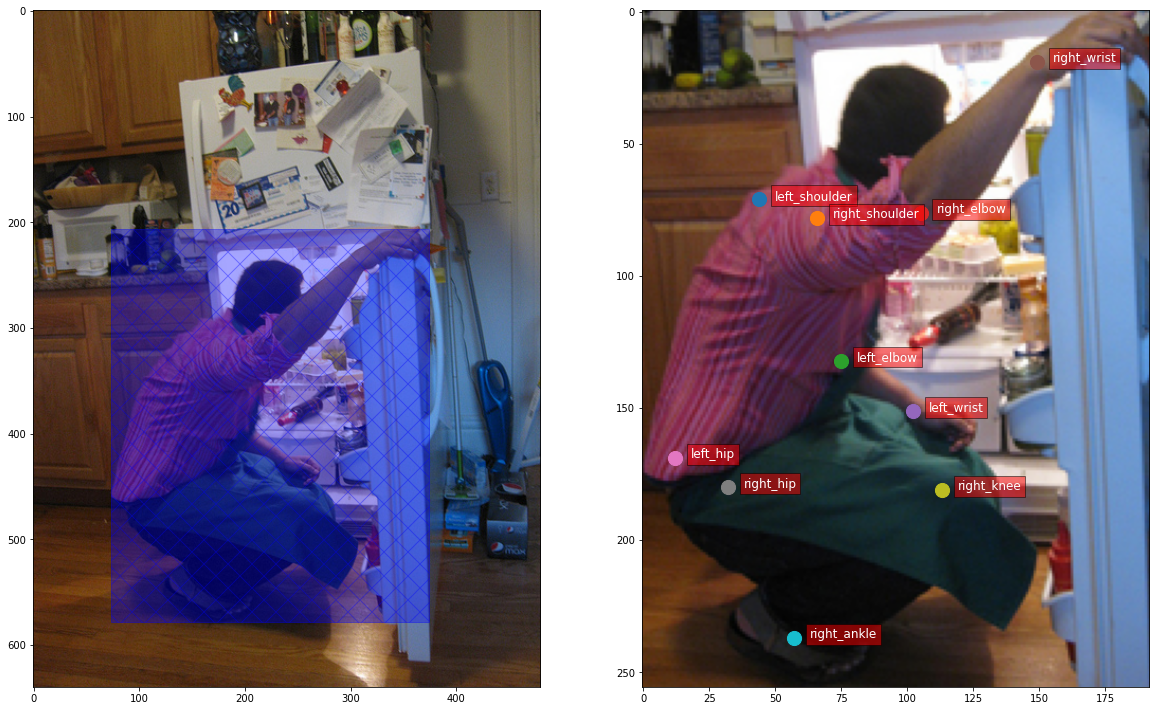

In [6]:
# plot coco image
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
# plot keypoints on image
def plot_keypoints(keypoints,keypoint_scores,keypoint_names,ax):
    score_threshold = 0.5
  
    for j in range(len(keypoint_names)):
        n = keypoint_names[j]
        x = keypoints[j,0]
        y = keypoints[j,1]

        if keypoint_scores[j]>score_threshold:
          ax.scatter(x, y, 200)
          ax.text(x+6, y, n, fontsize=12,bbox=dict(facecolor='red', alpha=0.5),color='w')
      
# show original and resized image
fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(121)  # left side
ax1.imshow(img_orig)
ax1.add_patch(Rectangle((x_start, y_start), box_w, box_h, alpha=0.35, facecolor="blue", edgecolor="blue", hatch='x'))

ax2 = fig.add_subplot(122)  # right side
ax2.imshow(img_rescaled)
ax2 = plot_keypoints(keypoints,gt_validity,kp_categories,ax2)
plt.show()